In [0]:
SEED = 100

In [0]:
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# By default Colab runs on TF1.x, to use TF2 - put this statement at the top
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
# Confirm we are using the right version
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import math
import random
import numpy as np
import pandas as pd
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model

In [0]:
sns.set(rc={'figure.figsize': (15, 9)})
sns.set_style('whitegrid')

In [0]:
def set_random_seeds():
   os.environ['PYTHONHASHSEED'] = str(SEED)
   tf.random.set_seed(SEED)
   np.random.seed(SEED)
   random.seed(SEED)

In [0]:
set_random_seeds()

In [9]:
from google.colab import files
files.upload()

Saving TSLA.csv to TSLA.csv


{'TSLA.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\n2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300\n2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100\n2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800\n2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800\n2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900\n2010-07-07,16.400000,16.629999,14.980000,15.800000,15.800000,6921700\n2010-07-08,16.139999,17.520000,15.570000,17.459999,17.459999,7711400\n2010-07-09,17.580000,17.900000,16.549999,17.400000,17.400000,4050600\n2010-07-12,17.950001,18.070000,17.000000,17.049999,17.049999,2202500\n2010-07-13,17.389999,18.639999,16.900000,18.139999,18.139999,2680100\n2010-07-14,17.940001,20.150000,17.760000,19.840000,19.840000,4195200\n2010-07-15,19.940001,21.500000,19.000000,19.889999,19.889999,3739800\n2010-07-16,20.700001,21.299999,20.049999,20.639999,20.639999,2621300\n2010-07-19,21.370001,22.250000

**Read the data**

In [0]:
df = pd.read_csv('TSLA.csv')

In [11]:
df.shape

(2416, 7)

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [13]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [0]:
df['Date'] = pd.to_datetime(df['Date'])

**EDA**

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


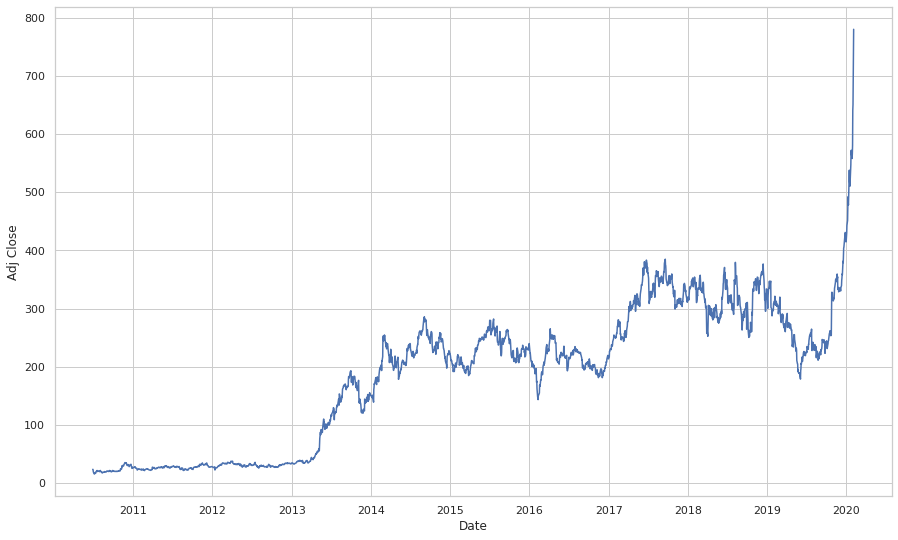

In [15]:
sns.lineplot(x='Date', y='Adj Close', data=df)

**Split data into training, validation and testing**

In [16]:
train_df, validation_df, test_df = np.split(df, [int(.6*len(df)), int(.8*len(df))])
train_validation_df = pd.concat([train_df, validation_df], axis=0, ignore_index=True, sort=False)

print(f'Train count: {train_df.shape[0]}')
print(f'Validation count: {validation_df.shape[0]}')
print(f'Train validation count: {train_validation_df.shape[0]}')
print(f'Test count: {test_df.shape[0]}')

print('\n')
print(f"Train daterange: {train_df['Date'].min()} - {train_df['Date'].max()}")
print(f"Validation daterange: {validation_df['Date'].min()} - {validation_df['Date'].max()}")
print(f"Train validation daterange: {train_validation_df['Date'].min()} - {train_validation_df['Date'].max()}")
print(f"Test daterange: {test_df['Date'].min()} - {test_df['Date'].max()}")

Train count: 1449
Validation count: 483
Train validation count: 1932
Test count: 484


Train daterange: 2010-06-29 00:00:00 - 2016-03-31 00:00:00
Validation daterange: 2016-04-01 00:00:00 - 2018-03-01 00:00:00
Train validation daterange: 2010-06-29 00:00:00 - 2018-03-01 00:00:00
Test daterange: 2018-03-02 00:00:00 - 2020-02-03 00:00:00


**Scale the data**

In [0]:
# Initial config (without tuning)
DEFAULT_N = 9  # For feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
DEFAULT_LSTM_UNITS = 50
DEFAULT_DROPOUT = 0.5
DEFAULT_EPOCHS = 1
DEFAULT_BATCH_SIZE = 1

In [0]:
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)

    For feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])

    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [0]:
# Fit on only the train dataset, and not the entire dataset to prevent information leak
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train_df['Adj Close']).reshape(-1,1))
train_validation_scaled = scaler.transform(np.array(train_validation_df['Adj Close']).reshape(-1,1))

In [0]:
x_train, y_train = get_x_y(train_scaled, DEFAULT_N, DEFAULT_N)
x_validation, y_validation = get_x_y(train_validation_scaled, DEFAULT_N, train_df.shape[0])

In [0]:
# Fit on train and validation for final model
scaler_final = MinMaxScaler(feature_range=(0, 1))
train_validation_scaled_final = scaler_final.fit_transform(np.array(train_validation_df['Adj Close']).reshape(-1, 1))
test_scaled  = scaler_final.transform(np.array(df['Adj Close']).reshape(-1,1))

**Create the model network**

In [0]:
# Create the initial benchmark LSTM network
set_random_seeds()
model = Sequential()
model.add(LSTM(units=DEFAULT_LSTM_UNITS, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(DEFAULT_DROPOUT))
model.add(LSTM(units=DEFAULT_LSTM_UNITS))
model.add(Dropout(DEFAULT_DROPOUT))
model.add(Dense(1))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 9, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


**Train the model**

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')
# Starting values before any tuning
model.fit(x_train, y_train, epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH_SIZE)

Train on 1440 samples
1440/1440 [==============================] - 14s 10ms/sample - loss: 0.0151


**Predict on validation**

In [0]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
# Get predictions
preds = model.predict(x_validation)
preds_inv = scaler.inverse_transform(preds)

# Get correct scale of y_validation
y_validation_inv = scaler.inverse_transform(y_validation)

# Calculate RMSE
rmse_before_tuning = math.sqrt(mean_squared_error(y_validation_inv, preds_inv))
print('RMSE = %0.3f' % rmse_before_tuning)

# Calculate MAPE
mape_before_tuning = get_mape(y_validation_inv, preds_inv)
print('MAPE = %0.3f%%' % mape_before_tuning)

RMSE = 26.518
MAPE = 6.939%


Text(0, 0.5, 'Adj Close')

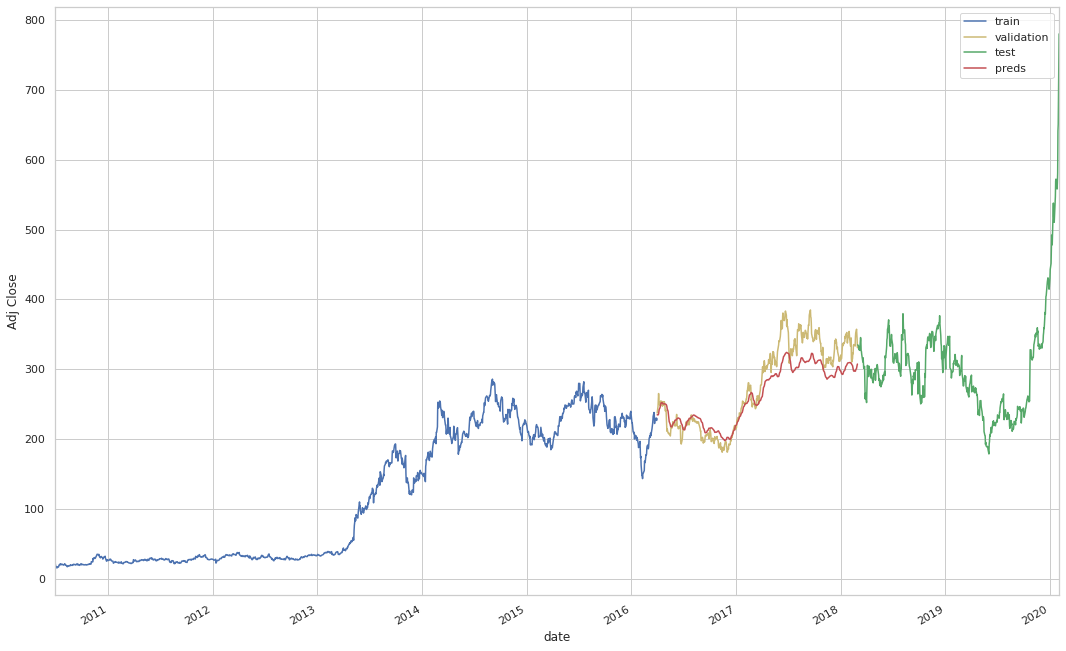

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 12

preds_df = pd.DataFrame({
    'preds_inv': preds_inv.reshape(-1), 
    'y_validation_inv': y_validation_inv.reshape(-1),
    'date': validation_df['Date']
})

ax = train_df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = validation_df.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test_df.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = preds_df.plot(x='date', y='preds_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'preds'])
ax.set_xlabel('date')
ax.set_ylabel('Adj Close')

**Tuning N (no. of days to use as features)**

In [0]:
def eval_model(n=DEFAULT_N, lstm_units=DEFAULT_LSTM_UNITS, dropout_prob=DEFAULT_DROPOUT, epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH_SIZE):
    x_train, y_train = get_x_y(train_scaled, n, n)
    x_validation, y_validation = get_x_y(train_validation_scaled, n, train_df.shape[0])

    # Create the LSTM network
    set_random_seeds()
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Get predictions
    preds = model.predict(x_validation)
    preds_inv = scaler.inverse_transform(preds)

    # Get correct scale of y_validation
    y_validation_inv = scaler.inverse_transform(y_validation)

    # Calculate RMSE & MAPE
    rmse = math.sqrt(mean_squared_error(y_validation_inv, preds_inv))
    mape = get_mape(y_validation_inv, preds_inv)

    return (rmse, mape)

In [31]:
param_list = range(2, 15)
error_df_list = []

for param in param_list:
    print(f'Running for N={param}')
    rmse, mape = eval_model(n=param)
    error_df_list.append({'n': param, 'rmse': rmse, 'mape': mape})

error_df = pd.DataFrame(error_df_list)
error_df = error_df[['n', 'mape', 'rmse']]
error_df.sort_values('mape').head(10)

Running for N=2
Running for N=3
Running for N=4
Running for N=5
Running for N=6
Running for N=7
Running for N=8
Running for N=9
Running for N=10
Running for N=11
Running for N=12
Running for N=13
Running for N=14


,n,mape,rmse
0,2,2.148953,8.071115
2,4,4.208847,15.752689
3,5,4.821170,17.789339
4,6,5.238050,15.668235
5,7,6.812440,27.201282
10,12,6.821531,25.685259
7,9,6.939289,26.517553
1,3,10.470181,29.753558
11,13,12.470136,46.354298
12,14,13.009569,48.734329


*Optimum value of N = 4*

**Tuning epochs and batch size**

In [32]:
epoch_list = [1, 10, 20, 30, 40, 50]
batch_size_list = [1, 8, 16, 32, 64, 128]
error_df_list = []

for epoch in epoch_list:
    for batch_size in batch_size_list:
      print(f'Running for #epochs={epoch}, batch size={batch_size}')
      rmse, mape = eval_model(n=4, epochs=epoch, batch_size=batch_size)
      error_df_list.append({'epochs': epoch, 'batch_size': batch_size, 'rmse': rmse, 'mape': mape})

error_df = pd.DataFrame(error_df_list)
error_df = error_df[['epochs', 'batch_size', 'mape', 'rmse']]
error_df.sort_values('mape').head(10)

Running for #epochs=1, batch size=1
Running for #epochs=1, batch size=8
Running for #epochs=1, batch size=16
Running for #epochs=1, batch size=32
Running for #epochs=1, batch size=64
Running for #epochs=1, batch size=128
Running for #epochs=10, batch size=1
Running for #epochs=10, batch size=8
Running for #epochs=10, batch size=16
Running for #epochs=10, batch size=32
Running for #epochs=10, batch size=64
Running for #epochs=10, batch size=128
Running for #epochs=20, batch size=1
Running for #epochs=20, batch size=8
Running for #epochs=20, batch size=16
Running for #epochs=20, batch size=32
Running for #epochs=20, batch size=64
Running for #epochs=20, batch size=128
Running for #epochs=30, batch size=1
Running for #epochs=30, batch size=8
Running for #epochs=30, batch size=16
Running for #epochs=30, batch size=32
Running for #epochs=30, batch size=64
Running for #epochs=30, batch size=128
Running for #epochs=40, batch size=1
Running for #epochs=40, batch size=8
Running for #epochs=40, 

,epochs,batch_size,mape,rmse
10,10,64,2.798015,10.177925
1,1,8,3.667891,13.891148
11,10,128,4.005819,12.722021
8,10,16,4.078410,15.416547
32,50,16,4.161246,16.037746
0,1,1,4.208847,15.752689
25,40,8,4.644655,18.848772
2,1,16,4.710061,14.580412
35,50,128,4.774625,18.404012
6,10,1,4.910260,20.196347


*Optimum value of # of epochs = 10*

*Optimum value of batch size = 64*

**Tuning # of units and dropout probability**

In [34]:
units_list = [10, 50, 64, 128]
dropout_prob_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
error_df_list = []

for unit in units_list:
    for dropout_prob in dropout_prob_list:
      print(f'Running for #units={unit}, dropout_prob={dropout_prob}')
      rmse, mape = eval_model(n=4, epochs=10, batch_size=64, lstm_units=unit, dropout_prob=dropout_prob)
      error_df_list.append({'units': unit, 'dropout_prob': dropout_prob, 'rmse': rmse, 'mape': mape})

error_df = pd.DataFrame(error_df_list)
error_df = error_df[['units', 'dropout_prob', 'mape', 'rmse']]
error_df.sort_values('mape').head(10)

Running for #units=10, dropout_prob=0
Running for #units=10, dropout_prob=0.1
Running for #units=10, dropout_prob=0.2
Running for #units=10, dropout_prob=0.3
Running for #units=10, dropout_prob=0.4
Running for #units=10, dropout_prob=0.5
Running for #units=50, dropout_prob=0
Running for #units=50, dropout_prob=0.1
Running for #units=50, dropout_prob=0.2
Running for #units=50, dropout_prob=0.3
Running for #units=50, dropout_prob=0.4
Running for #units=50, dropout_prob=0.5
Running for #units=64, dropout_prob=0
Running for #units=64, dropout_prob=0.1
Running for #units=64, dropout_prob=0.2
Running for #units=64, dropout_prob=0.3
Running for #units=64, dropout_prob=0.4
Running for #units=64, dropout_prob=0.5
Running for #units=128, dropout_prob=0
Running for #units=128, dropout_prob=0.1
Running for #units=128, dropout_prob=0.2
Running for #units=128, dropout_prob=0.3
Running for #units=128, dropout_prob=0.4
Running for #units=128, dropout_prob=0.5


,units,dropout_prob,mape,rmse
18,128,0.0,2.760272,10.081243
19,128,0.1,2.767991,10.135934
11,50,0.5,2.798015,10.177925
15,64,0.3,2.803931,10.195604
14,64,0.2,2.847194,10.512094
17,64,0.5,2.889408,10.471841
12,64,0.0,2.891094,10.755224
16,64,0.4,2.897075,10.356651
7,50,0.1,2.914404,10.816894
9,50,0.3,2.921356,10.917496


*Optimum value of # of units = 128*

*Optimum value of dropout_prob = 0.1*

**Find predictions on test set using best model**

In [41]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_validation_scaled_final, 4, 4)

# Split test into x and y
x_test_scaled, y_test_scaled = get_x_y(test_scaled, 4, train_df.shape[0]+validation_df.shape[0])

## Train, predict and eval model

# Create the LSTM network
set_random_seeds()
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train_cv_scaled.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(1))

# Compile and fit the LSTM network
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_cv_scaled, y_train_cv_scaled, epochs=10, batch_size=64)

# Get predictions
preds = model.predict(x_test_scaled)
preds_inv = scaler.inverse_transform(preds)

# Get correct scale of y_test
y_test_inv = scaler.inverse_transform(y_test_scaled)

# Calculate RMSE & MAPE
rmse = math.sqrt(mean_squared_error(y_test_inv, preds_inv))
mape = get_mape(y_test_inv, preds_inv)
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % mape)

Train on 1928 samples
Epoch 1/10
1928/1928 [==============================] - 2s 1ms/sample - loss: 0.0514
Epoch 2/10
1928/1928 [==============================] - 0s 75us/sample - loss: 0.0017
Epoch 3/10
1928/1928 [==============================] - 0s 79us/sample - loss: 9.5771e-04
Epoch 4/10
1928/1928 [==============================] - 0s 82us/sample - loss: 9.5403e-04
Epoch 5/10
1928/1928 [==============================] - 0s 78us/sample - loss: 9.5520e-04
Epoch 6/10
1928/1928 [==============================] - 0s 81us/sample - loss: 9.4673e-04
Epoch 7/10
1928/1928 [==============================] - 0s 83us/sample - loss: 8.8210e-04
Epoch 8/10
1928/1928 [==============================] - 0s 90us/sample - loss: 8.4065e-04
Epoch 9/10
1928/1928 [==============================] - 0s 83us/sample - loss: 8.7989e-04
Epoch 10/10
1928/1928 [==============================] - 0s 84us/sample - loss: 8.7924e-04
RMSE on test set = 14.542
MAPE on test set = 4.058%


Text(0, 0.5, 'Adj Close')

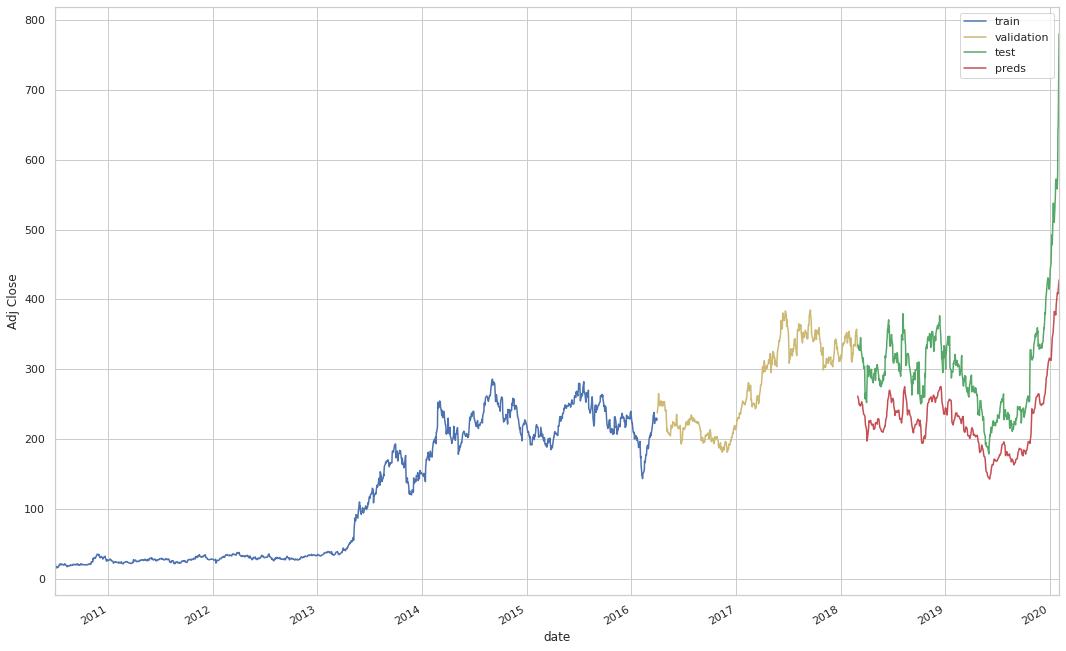

In [43]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 12

preds_df = pd.DataFrame({
    'preds_inv': preds_inv.reshape(-1), 
    'date': test_df['Date']
})

ax = train_df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = validation_df.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test_df.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = preds_df.plot(x='date', y='preds_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'preds'])
ax.set_xlabel('date')
ax.set_ylabel('Adj Close')

**RMSE on test set = 14.542**
<br/>
**MAPE on test set = 4.058%**